# Exploratory Data Analysis for Mass Spectra Prediction

## Overview
This notebook provides comprehensive exploratory data analysis (EDA) for understanding molecular features and mass spectra targets. The analysis covers:

- **Target Distribution Analysis**: Sparsity, intensity distributions, and spectral complexity
- **Feature Quality Assessment**: Variance, correlations, and distributions
- **Chemical Space Coverage**: PCA analysis and molecular property distributions
- **Cosine Similarity Insights**: Optimization strategies for spectral similarity

### Key Metrics:

**Cosine Similarity**: Measures spectral shape similarity
$$\text{cosine\_sim}(y, \hat{y}) = \frac{y \cdot \hat{y}}{||y|| \cdot ||\hat{y}||}$$

**Spectral Entropy**: Measures complexity of mass spectrum
$$H = -\sum_{i} p_i \log_{2}(p_i)$$
where $p_i$ is normalized intensity

### Input Requirements
- Featurized data files from the featurization pipeline (train/val/test splits)
- Data should be in JSONL format with 'smiles', 'features', and 'target' fields

## 1. Environment Setup and Configuration

Import all required libraries and set up the analysis configuration.

In [2]:
# Standard libraries
import os
import json
import warnings
from typing import Dict, List, Tuple, Optional, Any

# Data manipulation and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Statistical analysis
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency, pearsonr
from scipy.spatial.distance import cosine
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Machine learning utilities
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity

# Chemistry libraries
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds

# Configure warnings and plotting
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Master Configuration
MASTER_CONFIG = {
    # Data configuration
    'data': {
        'results_dir': '../data/results',
        'input_type': 'hpj',
        'use_selected_data': False,
    },
    
    # Analysis thresholds
    'analysis': {
        'sparsity_threshold': 0.95,
        'low_variance_threshold': 1e-6,
        'high_correlation_threshold': 0.95,
        'peak_threshold_percentile': 95,
        'mz_regions': 10,
        'pca_components': 2,
        'significance_level': 0.05
    },
    
    # Visualization settings
    'viz': {
        'figure_dpi': 100,
        'save_figures': False,
        'output_dir': 'eda_figures'
    }
}

# Utility functions
def load_jsonl_data(filepath: str) -> Tuple[List[str], np.ndarray, np.ndarray]:
    """Load data from JSONL file."""
    smiles_list, features, targets = [], [], []
    
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return smiles_list, np.array([]), np.array([])
    
    with open(filepath, 'r') as f:
        for line in f:
            try:
                record = json.loads(line)
                if all(key in record for key in ['smiles', 'features', 'target']):
                    smiles_list.append(record['smiles'])
                    features.append(record['features'])
                    targets.append(record['target'])
            except (json.JSONDecodeError, KeyError):
                continue
    
    print(f"Loaded {len(smiles_list)} samples from {os.path.basename(filepath)}")
    return smiles_list, np.array(features), np.array(targets)

def calculate_spectral_entropy(spectrum: np.ndarray) -> float:
    """Calculate the entropy of a mass spectrum."""
    if np.sum(spectrum) == 0:
        return 0
    probs = spectrum / np.sum(spectrum)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs)) if len(probs) > 1 else 0

def save_figure(fig, name: str):
    """Save figure if configured."""
    if MASTER_CONFIG['viz']['save_figures']:
        os.makedirs(MASTER_CONFIG['viz']['output_dir'], exist_ok=True)
        output_path = os.path.join(MASTER_CONFIG['viz']['output_dir'], f"{name}.png")
        fig.savefig(output_path, dpi=MASTER_CONFIG['viz']['figure_dpi'], bbox_inches='tight')

print("Environment setup complete!")

Environment setup complete!


## 2. Data Loading

Load train, validation, and test datasets from the featurization pipeline.

In [3]:
# Construct data paths
input_type_dir = os.path.join(MASTER_CONFIG['data']['results_dir'], 
                             MASTER_CONFIG['data']['input_type'])
data_subdir = "selected" if MASTER_CONFIG['data']['use_selected_data'] else "full_featurised"
data_dir = os.path.join(input_type_dir, data_subdir)

# Load all datasets
print("Loading datasets for EDA analysis...")
print(f"Data directory: {data_dir}")
print("=" * 70)

train_smiles, X_train, y_train = load_jsonl_data(os.path.join(data_dir, 'train_data.jsonl'))
val_smiles, X_val, y_val = load_jsonl_data(os.path.join(data_dir, 'val_data.jsonl'))
test_smiles, X_test, y_test = load_jsonl_data(os.path.join(data_dir, 'test_data.jsonl'))

# Combine all data for comprehensive analysis
all_smiles = train_smiles + val_smiles + test_smiles
X_all = np.vstack([X_train, X_val, X_test]) if len(X_train) > 0 else np.array([])
y_all = np.vstack([y_train, y_val, y_test]) if len(y_train) > 0 else np.array([])

# Create dataset labels for tracking
dataset_labels = (['train'] * len(train_smiles) + 
                 ['val'] * len(val_smiles) + 
                 ['test'] * len(test_smiles))

# Summary statistics
print(f"\nDataset Summary:")
print(f"{'Split':<10} {'Samples':<10} {'Percentage':<10}")
print("-" * 30)
for split, count in [('Train', len(train_smiles)), ('Val', len(val_smiles)), ('Test', len(test_smiles))]:
    print(f"{split:<10} {count:<10} {count/len(all_smiles)*100:<10.1f}%")
print(f"{'Total':<10} {len(all_smiles):<10} {100.0:<10.1f}%")

if len(X_all) > 0:
    print(f"\nData Dimensions:")
    print(f"  Features: {X_all.shape[1]}")
    print(f"  Spectrum length: {y_all.shape[1]} m/z points")

Loading datasets for EDA analysis...
Data directory: ../data/results/hpj/full_featurised
Loaded 2176 samples from train_data.jsonl
Loaded 272 samples from val_data.jsonl
Loaded 272 samples from test_data.jsonl

Dataset Summary:
Split      Samples    Percentage
------------------------------
Train      2176       80.0      %
Val        272        10.0      %
Test       272        10.0      %
Total      2720       100.0     %

Data Dimensions:
  Features: 7137
  Spectrum length: 500 m/z points


## 3. Target Distribution Analysis

Comprehensive analysis of mass spectra characteristics including sparsity, intensity distributions, and complexity.

ANALYZING TARGET DISTRIBUTION (SPECTRA CHARACTERISTICS)

Key Findings:
  Sparsity: 74.4% zeros
  Dynamic range: 1.0e+03
  Mean peaks per spectrum: 6.4 ± 10.0
  Mean spectral entropy: 4.65 ± 1.16


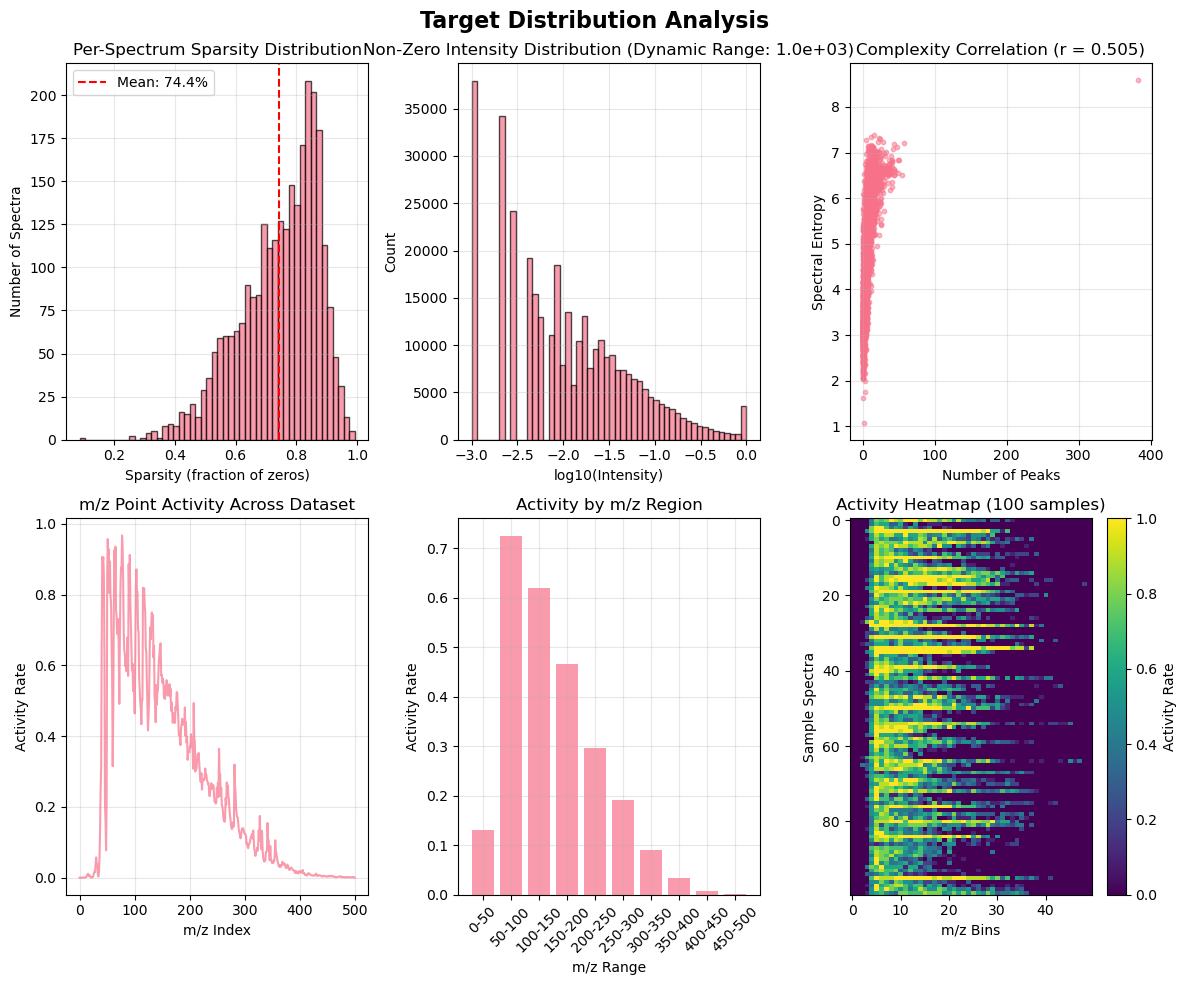

In [13]:
def comprehensive_target_analysis(spectra: np.ndarray, config: Dict) -> Dict[str, Any]:
    """Complete target distribution analysis with integrated visualization."""
    print("ANALYZING TARGET DISTRIBUTION (SPECTRA CHARACTERISTICS)")
    print("=" * 70)
    
    # 1. Sparsity Analysis
    zero_fraction = np.mean(spectra == 0)
    spectrum_sparsities = np.mean(spectra == 0, axis=1)
    mz_activity = np.mean(spectra > 0, axis=0)
    
    # 2. Intensity Analysis
    nonzero_intensities = spectra[spectra > 0]
    dynamic_range = np.max(spectra) / np.min(nonzero_intensities) if len(nonzero_intensities) > 0 else 0
    
    # 3. Complexity Analysis
    peak_threshold = np.percentile(nonzero_intensities, config['analysis']['peak_threshold_percentile']) if len(nonzero_intensities) > 0 else 0
    num_peaks_per_spectrum = np.sum(spectra > peak_threshold, axis=1)
    spectral_entropies = np.array([calculate_spectral_entropy(s) for s in spectra])
    
    # 4. m/z Range Activity
    num_regions = config['analysis']['mz_regions']
    region_size = spectra.shape[1] // num_regions
    region_activities = []
    
    for i in range(num_regions):
        start = i * region_size
        end = min((i + 1) * region_size, spectra.shape[1])
        region_activity = np.mean(spectra[:, start:end] > 0)
        region_activities.append(region_activity)
    
    # Print key findings
    print(f"\nKey Findings:")
    print(f"  Sparsity: {zero_fraction:.1%} zeros")
    print(f"  Dynamic range: {dynamic_range:.1e}")
    print(f"  Mean peaks per spectrum: {np.mean(num_peaks_per_spectrum):.1f} ± {np.std(num_peaks_per_spectrum):.1f}")
    print(f"  Mean spectral entropy: {np.mean(spectral_entropies):.2f} ± {np.std(spectral_entropies):.2f}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))
    fig.suptitle('Target Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Sparsity distribution
    axes[0,0].hist(spectrum_sparsities, bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].axvline(np.mean(spectrum_sparsities), color='red', linestyle='--', 
                     label=f'Mean: {np.mean(spectrum_sparsities):.1%}')
    axes[0,0].set_xlabel('Sparsity (fraction of zeros)')
    axes[0,0].set_ylabel('Number of Spectra')
    axes[0,0].set_title('Per-Spectrum Sparsity Distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Intensity distribution (log scale)
    if len(nonzero_intensities) > 0:
        axes[0,1].hist(np.log10(nonzero_intensities + 1e-10), bins=50, alpha=0.7, edgecolor='black')
        axes[0,1].set_xlabel('log10(Intensity)')
        axes[0,1].set_ylabel('Count')
        axes[0,1].set_title(f'Non-Zero Intensity Distribution (Dynamic Range: {dynamic_range:.1e})')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Complexity metrics
    axes[0,2].scatter(num_peaks_per_spectrum, spectral_entropies, alpha=0.5, s=10)
    correlation = np.corrcoef(num_peaks_per_spectrum, spectral_entropies)[0,1]
    axes[0,2].set_xlabel('Number of Peaks')
    axes[0,2].set_ylabel('Spectral Entropy')
    axes[0,2].set_title(f'Complexity Correlation (r = {correlation:.3f})')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. m/z activity profile
    axes[1,0].plot(mz_activity, alpha=0.7)
    axes[1,0].set_xlabel('m/z Index')
    axes[1,0].set_ylabel('Activity Rate')
    axes[1,0].set_title('m/z Point Activity Across Dataset')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Regional activity
    regions = [f"{i*region_size}-{(i+1)*region_size}" for i in range(num_regions)]
    axes[1,1].bar(range(num_regions), region_activities, alpha=0.7)
    axes[1,1].set_xlabel('m/z Range')
    axes[1,1].set_ylabel('Activity Rate')
    axes[1,1].set_title('Activity by m/z Region')
    axes[1,1].set_xticks(range(num_regions))
    axes[1,1].set_xticklabels(regions, rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Activity heatmap
    sample_size = min(100, len(spectra))
    sample_indices = np.random.choice(len(spectra), sample_size, replace=False)
    heatmap_data = []
    
    for idx in sample_indices:
        spectrum = spectra[idx]
        binned_activity = []
        for i in range(50):  # 50 bins across spectrum
            start = i * (len(spectrum) // 50)
            end = (i + 1) * (len(spectrum) // 50)
            binned_activity.append(np.mean(spectrum[start:end] > 0))
        heatmap_data.append(binned_activity)
    
    im = axes[1,2].imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[1,2].set_xlabel('m/z Bins')
    axes[1,2].set_ylabel('Sample Spectra')
    axes[1,2].set_title(f'Activity Heatmap ({sample_size} samples)')
    plt.colorbar(im, ax=axes[1,2], label='Activity Rate')
    
    plt.tight_layout()
    save_figure(fig, 'target_distribution_analysis')
    plt.show()
    
    # Return insights for summary
    return {
        'sparsity': zero_fraction,
        'dynamic_range': dynamic_range,
        'mean_peaks': np.mean(num_peaks_per_spectrum),
        'mean_entropy': np.mean(spectral_entropies),
        'peak_threshold': peak_threshold,
        'insights': {
            'is_very_sparse': zero_fraction > MASTER_CONFIG['analysis']['sparsity_threshold'],
            'high_dynamic_range': dynamic_range > 1e6,
            'complexity_level': 'high' if np.mean(num_peaks_per_spectrum) > 50 else 'moderate' if np.mean(num_peaks_per_spectrum) > 10 else 'low'
        }
    }

# Run target analysis
if len(y_all) > 0:
    target_results = comprehensive_target_analysis(y_all, MASTER_CONFIG)
else:
    print("No target data available for analysis")
    target_results = {}

## 4. Feature Quality Assessment

Analyze feature variance, correlations, and distributions to identify potential issues.


ANALYZING FEATURE QUALITY

Key Findings:
  Total features: 7137
  Zero variance features: 0
  Low variance features: 0
  High correlation pairs: 901
  Missing values: 0 (0.0%)


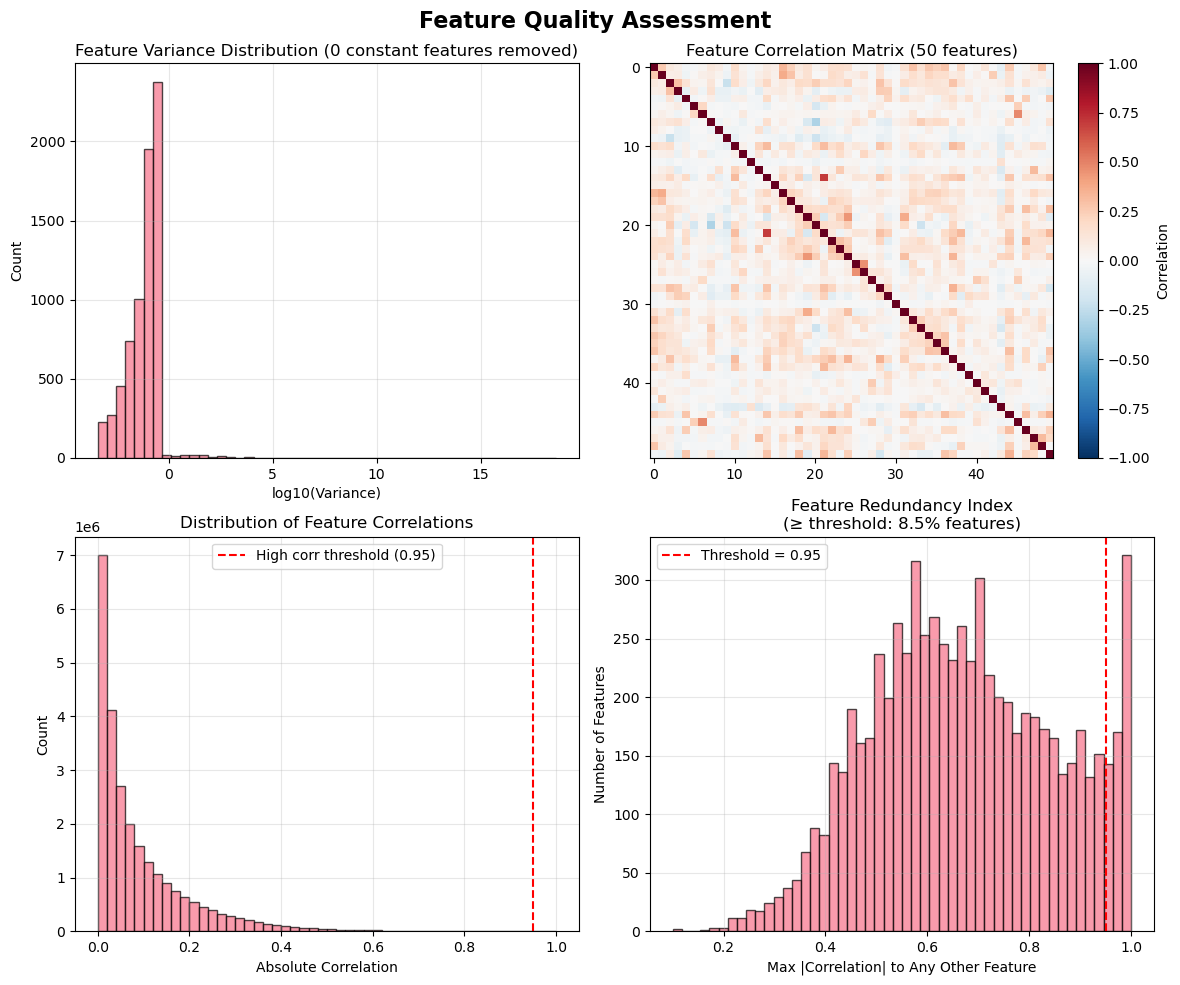

In [21]:
def comprehensive_feature_analysis(features: np.ndarray, config: Dict) -> Dict[str, Any]:
    """Complete feature quality analysis with integrated visualization."""
    print("\nANALYZING FEATURE QUALITY")
    print("=" * 70)
    
    # 1. Variance Analysis
    feature_variances = np.var(features, axis=0)
    zero_variance_features = np.where(feature_variances == 0)[0]
    low_variance_features = np.where(
        (feature_variances > 0) & 
        (feature_variances < config['analysis']['low_variance_threshold'])
    )[0]
    
    # 2. Correlation Analysis (sample for efficiency)
    sample_size = min(5000, len(features))
    sample_indices = np.random.choice(len(features), sample_size, replace=False)
    features_sample = features[sample_indices]
    
    correlation_matrix = np.corrcoef(features_sample.T)
    correlation_matrix = np.nan_to_num(correlation_matrix, nan=0.0)
    
    # Find high correlations (pair count above threshold)
    upper_triangle = np.triu(np.abs(correlation_matrix), k=1)
    high_corr_pairs = np.where(upper_triangle > config['analysis']['high_correlation_threshold'])
    
    # Redundancy index per feature = max |corr| to any other feature (excludes self)
    abs_corr = np.abs(correlation_matrix).copy()
    np.fill_diagonal(abs_corr, 0.0)
    max_abs_corr_per_feature = np.max(abs_corr, axis=1) if abs_corr.size else np.array([])
    
    # 3. Missing values check
    has_nan = np.any(np.isnan(features))
    has_inf = np.any(np.isinf(features))
    missing_count = np.sum(np.isnan(features)) + np.sum(np.isinf(features))
    
    # Print findings
    print(f"\nKey Findings:")
    print(f"  Total features: {features.shape[1]}")
    print(f"  Zero variance features: {len(zero_variance_features)}")
    print(f"  Low variance features: {len(low_variance_features)}")
    print(f"  High correlation pairs: {len(high_corr_pairs[0])}")
    print(f"  Missing values: {missing_count} ({missing_count/features.size:.1%})")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Feature Quality Assessment', fontsize=16, fontweight='bold')
    
    # 1. Variance distribution
    non_zero_variances = feature_variances[feature_variances > 0]
    if len(non_zero_variances) > 0:
        axes[0,0].hist(np.log10(non_zero_variances), bins=50, alpha=0.7, edgecolor='black')
        axes[0,0].set_xlabel('log10(Variance)')
        axes[0,0].set_ylabel('Count')
        axes[0,0].set_title(f'Feature Variance Distribution ({len(zero_variance_features)} constant features removed)')
        axes[0,0].grid(True, alpha=0.3)
    
    # 2. Correlation heatmap (subset)
    max_features_plot = min(50, correlation_matrix.shape[0])
    if max_features_plot > 1:
        feature_subset = np.random.choice(correlation_matrix.shape[0], max_features_plot, replace=False)
        corr_subset = correlation_matrix[np.ix_(feature_subset, feature_subset)]
        im = axes[0,1].imshow(corr_subset, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        axes[0,1].set_title(f'Feature Correlation Matrix ({max_features_plot} features)')
        plt.colorbar(im, ax=axes[0,1], label='Correlation')
    else:
        axes[0,1].axis('off')
        axes[0,1].text(0.5, 0.5, 'Not enough features for\ncorrelation heatmap', ha='center', va='center')
    
    # 3. Correlation distribution
    if correlation_matrix.size:
        all_correlations = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]
        abs_correlations = np.abs(all_correlations)
        axes[1,0].hist(abs_correlations, bins=50, alpha=0.7, edgecolor='black')
        axes[1,0].axvline(
            config['analysis']['high_correlation_threshold'], 
            color='red', linestyle='--', 
            label=f"High corr threshold ({config['analysis']['high_correlation_threshold']})"
        )
        axes[1,0].set_xlabel('Absolute Correlation')
        axes[1,0].set_ylabel('Count')
        axes[1,0].set_title('Distribution of Feature Correlations')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].axis('off')
        axes[1,0].text(0.5, 0.5, 'Correlation distribution\nnot available', ha='center', va='center')
    
    # 4.(bottom-right): Redundancy Index Histogram
    ax = axes[1,1]
    if max_abs_corr_per_feature.size:
        ax.hist(max_abs_corr_per_feature, bins=50, alpha=0.7, edgecolor='black')
        thr = config['analysis']['high_correlation_threshold']
        ax.axvline(thr, linestyle='--', linewidth=1.5, color='red', label=f'Threshold = {thr}')
        frac_redundant = np.mean(max_abs_corr_per_feature >= thr)
        ax.set_xlabel('Max |Correlation| to Any Other Feature')
        ax.set_ylabel('Number of Features')
        ax.set_title(f'Feature Redundancy Index\n(≥ threshold: {frac_redundant*100:.1f}% features)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')
        ax.text(0.5, 0.5, 'Redundancy index not available', ha='center', va='center')
    
    plt.tight_layout()
    save_figure(fig, 'feature_quality_assessment')
    plt.show()
    
    return {
        'num_features': features.shape[1],
        'zero_variance_features': zero_variance_features,
        'low_variance_features': low_variance_features,
        'high_corr_pairs': len(high_corr_pairs[0]),
        'has_missing': has_nan or has_inf,
        'insights': {
            'needs_cleaning': len(zero_variance_features) > 0,
            'high_multicollinearity': len(high_corr_pairs[0]) > 100,
            'dimensionality_reduction_recommended': len(high_corr_pairs[0]) > 100 or features.shape[1] > 1000
        }
    }

# Run feature analysis
if len(X_all) > 0:
    feature_results = comprehensive_feature_analysis(X_all, MASTER_CONFIG)
else:
    print("No feature data available for analysis")
    feature_results = {}

## 5. Chemical Space and Split Analysis

Analyze molecular properties and feature space coverage using PCA to ensure test set representativeness.


ANALYZING MOLECULAR PROPERTIES AND DATA SPLITS

Molecular Overlap:
  Train-Test overlap: 0
  Train-Val overlap: 0
  Val-Test overlap: 0
  ✓ No data leakage detected


Calculating train properties:  39%|███▉      | 391/1000 [00:00<00:00, 3902.78it/s][07:44:34] WARNING: not removing hydrogen atom without neighbors



Performing PCA analysis...


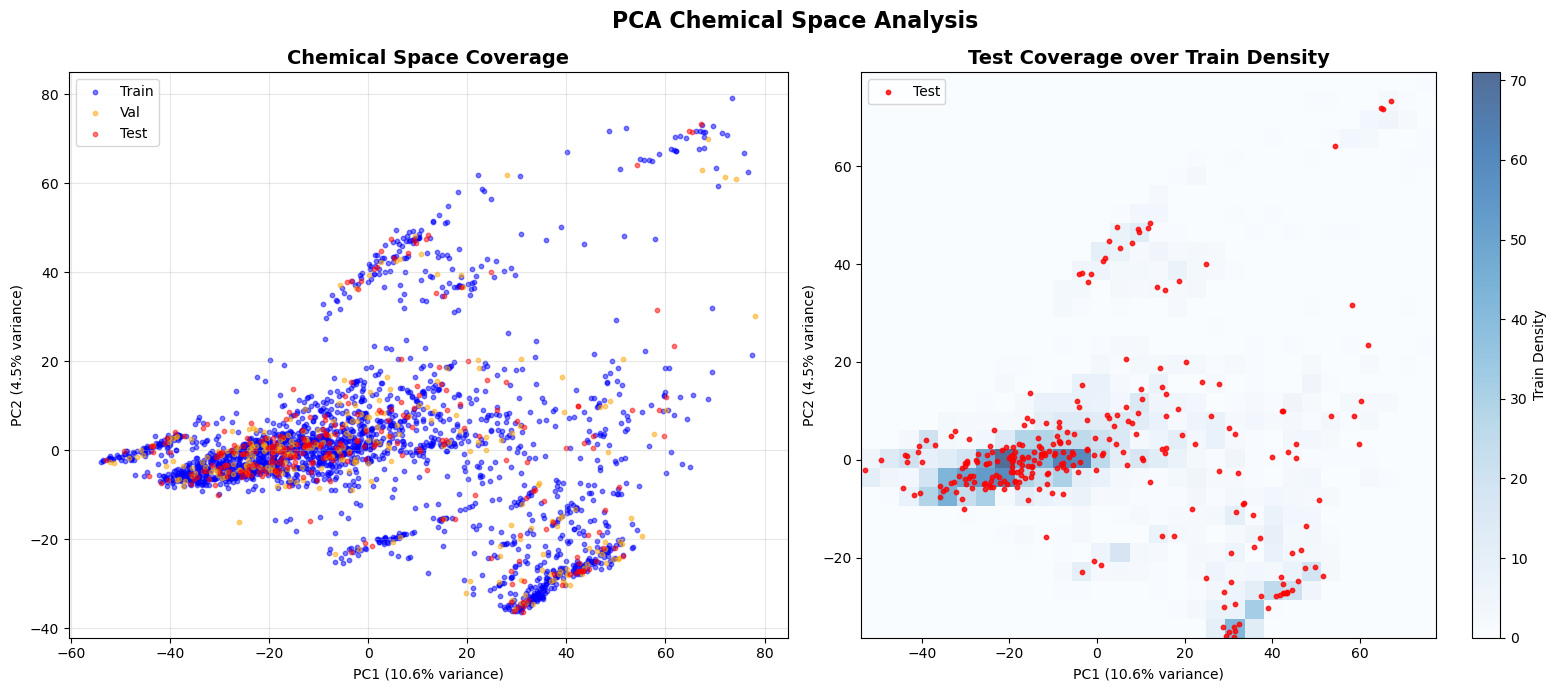

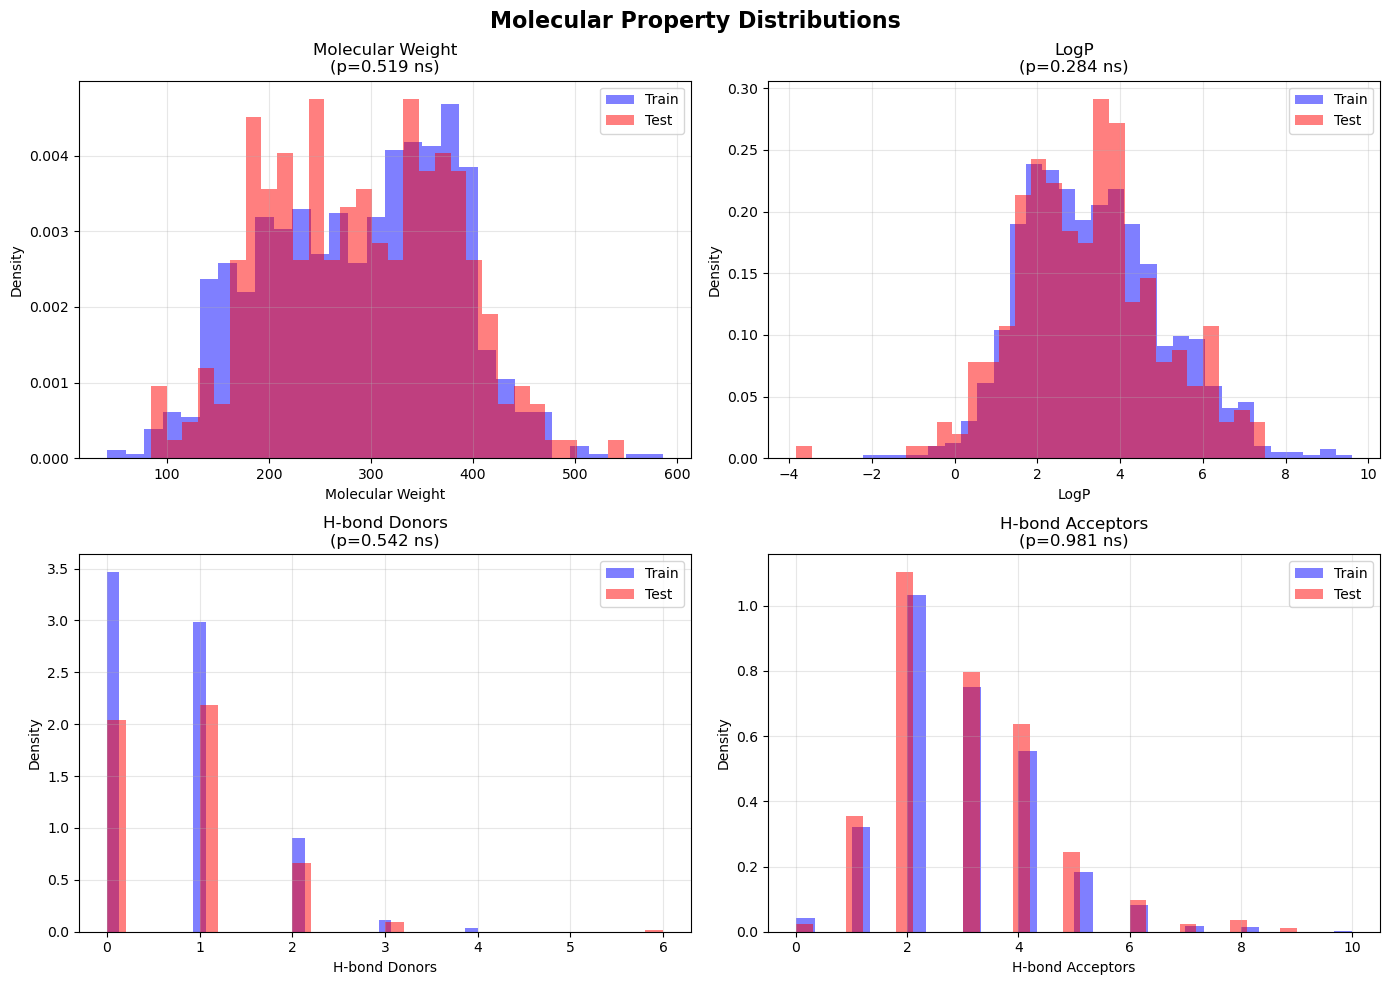


PCA Coverage Analysis:
  PC1 range ratio (test/train): 0.91
  PC2 range ratio (test/train): 0.95
  Explained variance: 15.2%


In [6]:
def analyze_molecular_properties_and_overlap(train_smiles, val_smiles, test_smiles):
    """Analyze molecular overlap and calculate chemical properties."""
    print("\nANALYZING MOLECULAR PROPERTIES AND DATA SPLITS")
    print("=" * 70)
    
    # Check molecular overlap
    train_set = set(train_smiles)
    val_set = set(val_smiles)
    test_set = set(test_smiles)
    
    train_test_overlap = len(train_set.intersection(test_set))
    train_val_overlap = len(train_set.intersection(val_set))
    val_test_overlap = len(val_set.intersection(test_set))
    
    print(f"\nMolecular Overlap:")
    print(f"  Train-Test overlap: {train_test_overlap}")
    print(f"  Train-Val overlap: {train_val_overlap}")
    print(f"  Val-Test overlap: {val_test_overlap}")
    
    if train_test_overlap > 0:
        print("  Data leakage detected between train and test sets!")
    else:
        print("  ✓ No data leakage detected")
    
    # Calculate molecular properties
    def calc_properties(smiles_list, name):
        properties = {'mw': [], 'logp': [], 'hbd': [], 'hba': [], 'tpsa': []}
        
        for smiles in tqdm(smiles_list[:1000], desc=f"Calculating {name} properties", leave=False):
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    properties['mw'].append(Descriptors.MolWt(mol))
                    properties['logp'].append(Crippen.MolLogP(mol))
                    properties['hbd'].append(Lipinski.NumHDonors(mol))
                    properties['hba'].append(Lipinski.NumHAcceptors(mol))
                    properties['tpsa'].append(Descriptors.TPSA(mol))
            except:
                continue
        
        return {k: np.array(v) for k, v in properties.items()}
    
    train_props = calc_properties(train_smiles, "train")
    test_props = calc_properties(test_smiles, "test")
    
    return {
        'overlap': {
            'train_test': train_test_overlap,
            'train_val': train_val_overlap,
            'val_test': val_test_overlap
        },
        'properties': {
            'train': train_props,
            'test': test_props
        }
    }

def chemical_space_visualization(features, labels, split_results, config):
    """Visualize chemical space coverage using PCA and molecular properties."""
    
    # PCA analysis
    print("\nPerforming PCA analysis...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    
    pca = PCA(n_components=config['analysis']['pca_components'])
    X_pca = pca.fit_transform(X_scaled)
    
    # Create masks for different splits
    train_mask = np.array(labels) == 'train'
    test_mask = np.array(labels) == 'test'
    val_mask = np.array(labels) == 'val'
    
    # Figure 1: PCA Analysis (1x2 subplot)
    fig_pca, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig_pca.suptitle('PCA Chemical Space Analysis', fontsize=16, fontweight='bold')
    
    # 1. PCA scatter plot
    for split, color, mask in [('train', 'blue', train_mask), 
                               ('val', 'orange', val_mask), 
                               ('test', 'red', test_mask)]:
        if np.any(mask):
            ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       alpha=0.5, s=10, label=split.capitalize(), c=color)
    
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.set_title('Chemical Space Coverage', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Density plot - train space with test overlay
    # Create 2D histogram for train data
    h = ax2.hist2d(X_pca[train_mask, 0], X_pca[train_mask, 1], 
                   bins=30, cmap='Blues', alpha=0.7)
    plt.colorbar(h[3], ax=ax2, label='Train Density')
    
    # Overlay test points
    ax2.scatter(X_pca[test_mask, 0], X_pca[test_mask, 1], 
               alpha=0.8, s=10, c='red', label='Test')
    
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax2.set_title('Test Coverage over Train Density', fontsize=14, fontweight='bold')
    ax2.legend()
    
    plt.tight_layout()
    save_figure(fig_pca, 'pca_chemical_space_analysis')
    plt.show()
    
    # Figure 2: Molecular property distributions
    if split_results and 'properties' in split_results:
        # 2x2 grid for four key properties
        fig_props, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig_props.suptitle('Molecular Property Distributions', fontsize=16, fontweight='bold')
        
        props = split_results['properties']
        prop_names = ['mw', 'logp', 'hbd', 'hba']  # show four in 2x2
        prop_labels = ['Molecular Weight', 'LogP', 'H-bond Donors', 'H-bond Acceptors']
        
        for i, (prop, label) in enumerate(zip(prop_names, prop_labels)):
            row, col = divmod(i, 2)
            ax = axes[row, col]
            
            if prop in props['train'] and len(props['train'][prop]) > 0:
                # Perform KS test
                if prop in props['test'] and len(props['test'][prop]) > 0:
                    ks_stat, p_val = ks_2samp(props['train'][prop], props['test'][prop])
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                    
                    ax.hist(props['train'][prop], bins=30, alpha=0.5, 
                            label='Train', density=True, color='blue')
                    ax.hist(props['test'][prop], bins=30, alpha=0.5, 
                            label='Test', density=True, color='red')
                    ax.set_title(f'{label}\n(p={p_val:.3f} {sig})')
                else:
                    ax.hist(props['train'][prop], bins=30, alpha=0.5, 
                            label='Train', density=True, color='blue')
                    ax.set_title(label)
                
                ax.set_xlabel(label)
                ax.set_ylabel('Density')
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        save_figure(fig_props, 'molecular_property_distributions')
        plt.show()
    
    # Print PCA coverage statistics
    train_range_pc1 = np.ptp(X_pca[train_mask, 0])
    test_range_pc1 = np.ptp(X_pca[test_mask, 0])
    train_range_pc2 = np.ptp(X_pca[train_mask, 1])
    test_range_pc2 = np.ptp(X_pca[test_mask, 1])
    
    print(f"\nPCA Coverage Analysis:")
    print(f"  PC1 range ratio (test/train): {test_range_pc1/train_range_pc1:.2f}")
    print(f"  PC2 range ratio (test/train): {test_range_pc2/train_range_pc2:.2f}")
    print(f"  Explained variance: {sum(pca.explained_variance_ratio_):.1%}")

# Run split analysis
if len(train_smiles) > 0 and len(X_all) > 0:
    split_results = analyze_molecular_properties_and_overlap(train_smiles, val_smiles, test_smiles)
    chemical_space_visualization(X_all, dataset_labels, split_results, MASTER_CONFIG)
else:
    print("Insufficient data for split analysis")
    split_results = {}

## 6. Cosine Similarity Optimization Insights

Analyze spectral characteristics relevant to cosine similarity prediction.


ANALYZING COSINE SIMILARITY OPTIMIZATION FACTORS

Key Findings:
  Vector norm CV: 0.365
  Mean pairwise similarity: 0.073
  Pattern vs intensity correlation: 0.773
  Similarity range: [0.000, 0.999]


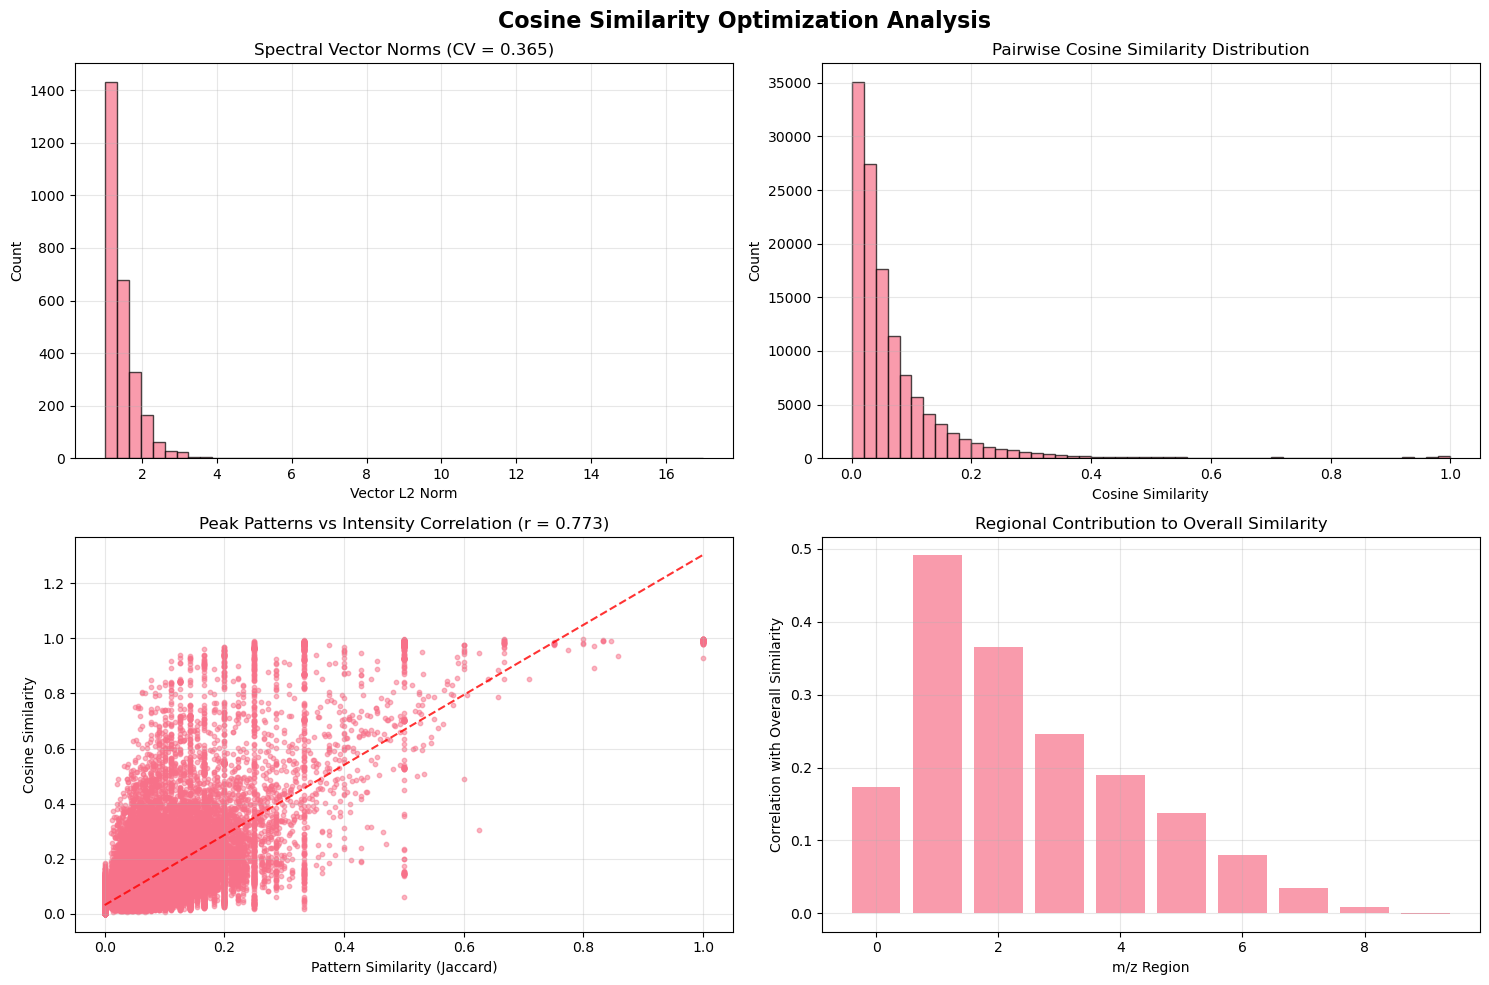

In [7]:
def cosine_similarity_analysis(spectra: np.ndarray, config: Dict) -> Dict[str, Any]:
    """Analyze spectral properties relevant to cosine similarity optimization."""
    print("\nANALYZING COSINE SIMILARITY OPTIMIZATION FACTORS")
    print("=" * 70)
    
    # Calculate vector norms
    vector_norms = np.linalg.norm(spectra, axis=1)
    norm_cv = np.std(vector_norms) / np.mean(vector_norms)
    
    # Sample for similarity analysis
    sample_size = min(500, len(spectra))
    sample_indices = np.random.choice(len(spectra), sample_size, replace=False)
    sample_spectra = spectra[sample_indices]
    
    # Calculate pairwise similarities
    cosine_sim_matrix = cosine_similarity(sample_spectra)
    upper_triangle = cosine_sim_matrix[np.triu_indices_from(cosine_sim_matrix, k=1)]
    
    # Analyze peak patterns vs intensity patterns
    peak_threshold = np.percentile(spectra[spectra > 0], 90)
    binary_patterns = (sample_spectra > peak_threshold).astype(int)
    
    # Compare pattern-based vs intensity-based similarities
    pattern_similarities = []
    for i in range(len(sample_indices)):
        for j in range(i+1, len(sample_indices)):
            # Jaccard similarity for patterns
            intersection = np.sum(binary_patterns[i] & binary_patterns[j])
            union = np.sum(binary_patterns[i] | binary_patterns[j])
            jaccard = intersection / union if union > 0 else 0
            pattern_similarities.append(jaccard)
    
    pattern_similarities = np.array(pattern_similarities)
    pattern_corr, _ = pearsonr(pattern_similarities, upper_triangle)
    
    # Normalization impact analysis
    normalized_spectra = normalize(sample_spectra, norm='l2')
    norm_sim_matrix = cosine_similarity(normalized_spectra)
    
    print(f"\nKey Findings:")
    print(f"  Vector norm CV: {norm_cv:.3f}")
    print(f"  Mean pairwise similarity: {np.mean(upper_triangle):.3f}")
    print(f"  Pattern vs intensity correlation: {pattern_corr:.3f}")
    print(f"  Similarity range: [{np.min(upper_triangle):.3f}, {np.max(upper_triangle):.3f}]")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Cosine Similarity Optimization Analysis', fontsize=16, fontweight='bold')
    
    # 1. Vector norm distribution
    axes[0,0].hist(vector_norms, bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Vector L2 Norm')
    axes[0,0].set_ylabel('Count')
    axes[0,0].set_title(f'Spectral Vector Norms (CV = {norm_cv:.3f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Cosine similarity distribution
    axes[0,1].hist(upper_triangle, bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Cosine Similarity')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Pairwise Cosine Similarity Distribution')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Pattern vs intensity correlation
    axes[1,0].scatter(pattern_similarities, upper_triangle, alpha=0.5, s=10)
    axes[1,0].set_xlabel('Pattern Similarity (Jaccard)')
    axes[1,0].set_ylabel('Cosine Similarity')
    axes[1,0].set_title(f'Peak Patterns vs Intensity Correlation (r = {pattern_corr:.3f})')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(pattern_similarities, upper_triangle, 1)
    p = np.poly1d(z)
    axes[1,0].plot(sorted(pattern_similarities), p(sorted(pattern_similarities)), "r--", alpha=0.8)
    
    # 4. Regional contribution analysis
    num_regions = 10
    region_size = sample_spectra.shape[1] // num_regions
    regional_correlations = []
    
    for i in range(num_regions):
        start = i * region_size
        end = min((i + 1) * region_size, sample_spectra.shape[1])
        
        regional_sims = cosine_similarity(sample_spectra[:, start:end])
        regional_upper = regional_sims[np.triu_indices_from(regional_sims, k=1)]
        
        if len(regional_upper) > 1 and len(upper_triangle) > 1:
            corr, _ = pearsonr(regional_upper, upper_triangle)
            regional_correlations.append(corr)
        else:
            regional_correlations.append(0)
    
    axes[1,1].bar(range(num_regions), regional_correlations, alpha=0.7)
    axes[1,1].set_xlabel('m/z Region')
    axes[1,1].set_ylabel('Correlation with Overall Similarity')
    axes[1,1].set_title('Regional Contribution to Overall Similarity')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_figure(fig, 'cosine_similarity_analysis')
    plt.show()
    
    return {
        'norm_cv': norm_cv,
        'mean_similarity': np.mean(upper_triangle),
        'pattern_correlation': pattern_corr,
        'insights': {
            'magnitude_importance': 'high' if norm_cv > 0.5 else 'low',
            'pattern_driven': pattern_corr > 0.7,
            'recommended_normalization': 'l2' if norm_cv > 0.5 else 'none'
        }
    }

# Run cosine similarity analysis
if len(y_all) > 0:
    cosine_results = cosine_similarity_analysis(y_all, MASTER_CONFIG)
else:
    print("No target data available for cosine similarity analysis")
    cosine_results = {}

## 7. Drug-Likeness Assessment

Comprehensive analysis of drug-like properties across the dataset, including Lipinski's Rule of Five, QED scores, and bioavailability metrics.

### Key Metrics:
- **Lipinski's Rule of Five**: MW ≤ 500 Da, LogP ≤ 5, HBD ≤ 5, HBA ≤ 10
- **QED Score**: Quantitative Estimate of Drug-likeness (0-1 scale)
- **Bioavailability Metrics**: TPSA, rotatable bonds, and other ADME-relevant properties


ANALYZING DRUG-LIKENESS PROPERTIES


Calculating train drug properties:  66%|██████▋   | 1445/2176 [00:01<00:00, 1035.93it/s][08:11:44] WARNING: not removing hydrogen atom without neighbors
[08:11:44] WARNING: not removing hydrogen atom without neighbors


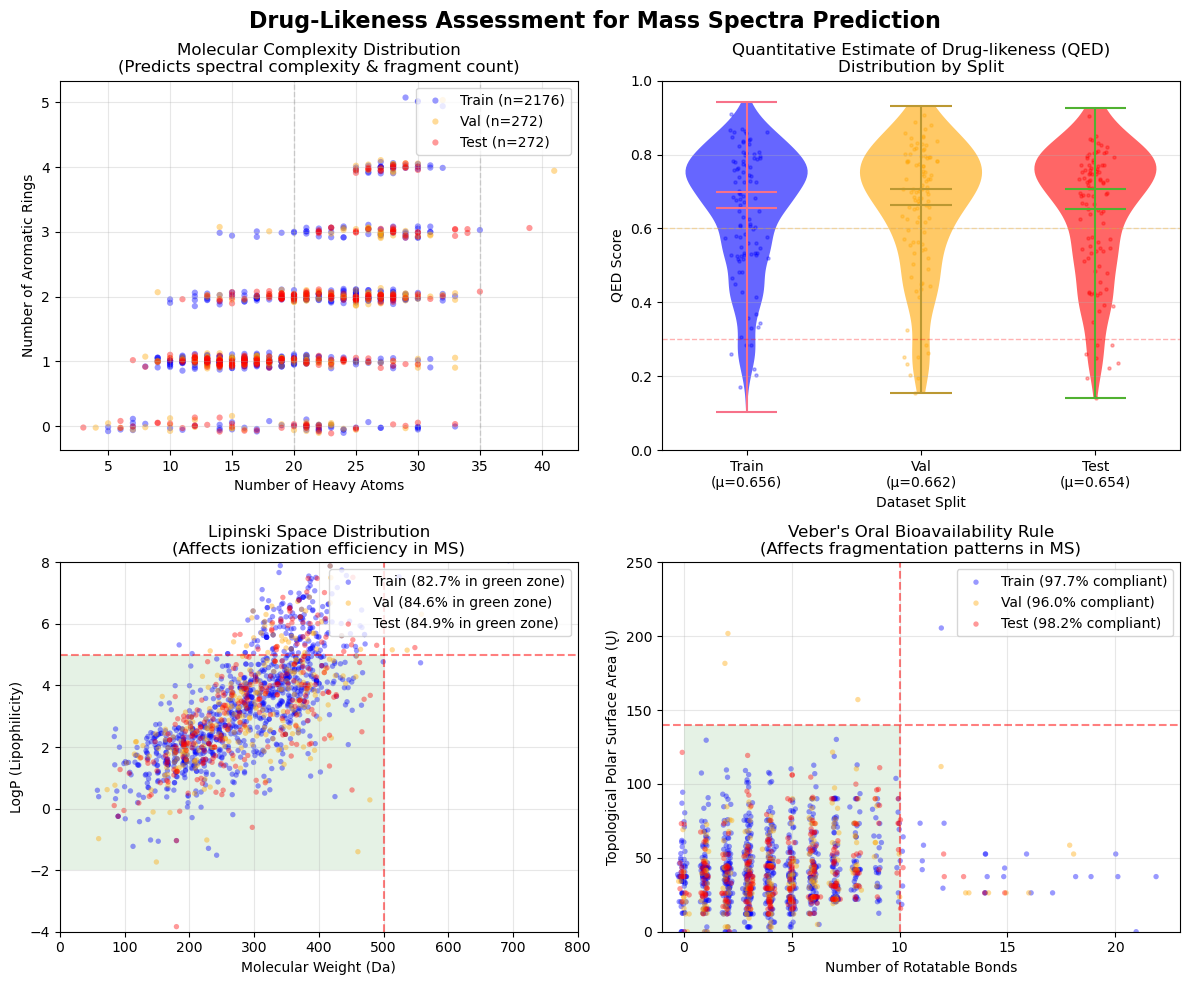


Key Findings:
----------------------------------------

TRAIN SET:
  Lipinski compliant (≤1 viol): nan%
  Mean QED score: 0.656 ± 0.168
  Veber compliant: 97.2%
  Mean MW: 284.0 ± 89.7 Da
  Mean LogP: 3.31 ± 1.73
  Mean TPSA: 40.2 ± 22.5 Ų
  Molecular complexity:
    - Heavy atoms: 20.3 ± 6.5
    - Aromatic rings: 1.6 ± 1.1
    - Heteroatoms: nan ± nan

VAL SET:
  Lipinski compliant (≤1 viol): nan%
  Mean QED score: 0.662 ± 0.175
  Veber compliant: 96.0%
  Mean MW: 287.3 ± 89.0 Da
  Mean LogP: 3.21 ± 1.62
  Mean TPSA: 42.4 ± 26.9 Ų
  Molecular complexity:
    - Heavy atoms: 20.4 ± 6.4
    - Aromatic rings: 1.6 ± 1.0
    - Heteroatoms: nan ± nan

TEST SET:
  Lipinski compliant (≤1 viol): nan%
  Mean QED score: 0.654 ± 0.172
  Veber compliant: 98.2%
  Mean MW: 288.6 ± 88.7 Da
  Mean LogP: 3.21 ± 1.71
  Mean TPSA: 42.5 ± 22.8 Ų
  Molecular complexity:
    - Heavy atoms: 20.5 ± 6.4
    - Aromatic rings: 1.6 ± 1.0
    - Heteroatoms: nan ± nan

Statistical Comparison (Train vs Test):
------

In [12]:
def drug_likeness_analysis(smiles_lists, labels, config):
    """Comprehensive drug-likeness analysis with visualization."""
    print("\nANALYZING DRUG-LIKENESS PROPERTIES")
    print("=" * 70)
    
    from rdkit.Chem import QED
    from rdkit.Chem.Lipinski import NumHDonors, NumHAcceptors
    
    # Calculate drug-likeness properties for each dataset
    def calculate_drug_properties(smiles_list, name, max_samples=5000):
        """Calculate comprehensive drug-likeness metrics."""
        properties = {
            'mw': [], 'logp': [], 'hbd': [], 'hba': [], 'tpsa': [],
            'rotatable_bonds': [], 'qed': [], 'lipinski_violations': [],
            'aromatic_rings': [], 'heavy_atoms': [], 'sp3_fraction': [],
            'num_heteroatoms': [], 'num_stereocenters': [], 'complexity': []
        }
        
        # Sample if dataset is large
        sample_size = min(max_samples, len(smiles_list))
        sampled_smiles = np.random.choice(smiles_list, sample_size, replace=False)
        
        for smiles in tqdm(sampled_smiles, desc=f"Calculating {name} drug properties", leave=False):
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    # Basic properties
                    mw = Descriptors.MolWt(mol)
                    logp = Crippen.MolLogP(mol)
                    hbd = NumHDonors(mol)
                    hba = NumHAcceptors(mol)
                    tpsa = Descriptors.TPSA(mol)
                    
                    properties['mw'].append(mw)
                    properties['logp'].append(logp)
                    properties['hbd'].append(hbd)
                    properties['hba'].append(hba)
                    properties['tpsa'].append(tpsa)
                    
                    # Additional drug-like properties
                    properties['rotatable_bonds'].append(CalcNumRotatableBonds(mol))
                    properties['qed'].append(QED.qed(mol))
                    properties['aromatic_rings'].append(Descriptors.NumAromaticRings(mol))
                    properties['heavy_atoms'].append(mol.GetNumHeavyAtoms())
                    properties['sp3_fraction'].append(Descriptors.FractionCsp3(mol))
                    properties['num_heteroatoms'].append(Descriptors.NumHeteroatoms(mol))
                    
                    # Molecular complexity (BertzCT)
                    properties['complexity'].append(Descriptors.BertzCT(mol))
                    
                    # Stereocenters (complexity metric)
                    stereo_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
                    properties['num_stereocenters'].append(len(stereo_centers))
                    
                    # Count Lipinski violations
                    violations = 0
                    if mw > 500: violations += 1
                    if logp > 5: violations += 1
                    if hbd > 5: violations += 1
                    if hba > 10: violations += 1
                    properties['lipinski_violations'].append(violations)
                    
            except Exception as e:
                continue
        
        return {k: np.array(v) for k, v in properties.items()}
    
    # Calculate properties for each split
    split_properties = {}
    split_names = []
    split_colors = []
    
    for smiles_list, label, color in [(train_smiles, 'train', 'blue'),
                                       (val_smiles, 'val', 'orange'),
                                       (test_smiles, 'test', 'red')]:
        if len(smiles_list) > 0:
            split_properties[label] = calculate_drug_properties(smiles_list, label)
            split_names.append(label)
            split_colors.append(color)
    
    # Create visualization with consistent sizing
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Match other plots in notebook
    fig.suptitle('Drug-Likeness Assessment for Mass Spectra Prediction', fontsize=16, fontweight='bold')
    
    # 1. Molecular Complexity vs Heavy Atoms (affects spectral complexity)
    ax1 = axes[0, 0]
    
    for split, color in zip(split_names, split_colors):
        if split in split_properties:
            heavy = split_properties[split]['heavy_atoms']
            aromatic = split_properties[split]['aromatic_rings']
            
            # Sample for scatter overlay
            if len(heavy) > 500:
                indices = np.random.choice(len(heavy), 500, replace=False)
                heavy_sample = heavy[indices]
                aromatic_sample = aromatic[indices]
            else:
                heavy_sample = heavy
                aromatic_sample = aromatic
            
            # Add small jitter for better visualization of discrete values
            aromatic_jitter = aromatic_sample + np.random.normal(0, 0.05, len(aromatic_sample))
            
            ax1.scatter(heavy_sample, aromatic_jitter, alpha=0.4, s=20, 
                       label=f'{split.capitalize()} (n={len(heavy)})', 
                       c=color, edgecolors='none')
    
    # Add complexity regions with vertical lines
    ax1.axvline(x=20, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax1.axvline(x=35, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    ax1.set_xlabel('Number of Heavy Atoms')
    ax1.set_ylabel('Number of Aromatic Rings')
    ax1.set_title('Molecular Complexity Distribution\n(Predicts spectral complexity & fragment count)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. QED score distribution (comprehensive drug-likeness metric)
    ax2 = axes[0, 1]
    qed_stats = {}
    
    for split, color in zip(split_names, split_colors):
        if split in split_properties and 'qed' in split_properties[split]:
            qed_scores = split_properties[split]['qed']
            
            # Create violin plot for better distribution visualization
            parts = ax2.violinplot([qed_scores], positions=[split_names.index(split)], 
                                   widths=0.7, showmeans=True, showmedians=True)
            
            # Customize violin colors
            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_alpha(0.6)
            
            # Stats for legend
            mean_qed = np.mean(qed_scores)
            qed_stats[split] = mean_qed
            
            # Add swarm plot overlay for actual data points (subsample for clarity)
            sample_indices = np.random.choice(len(qed_scores), 
                                            min(100, len(qed_scores)), replace=False)
            y_vals = qed_scores[sample_indices]
            x_vals = np.random.normal(split_names.index(split), 0.05, len(y_vals))
            ax2.scatter(x_vals, y_vals, alpha=0.3, s=5, c=color)
    
    ax2.set_xlabel('Dataset Split')
    ax2.set_ylabel('QED Score')
    ax2.set_title('Quantitative Estimate of Drug-likeness (QED)\nDistribution by Split')
    ax2.set_xticks(range(len(split_names)))
    ax2.set_xticklabels([f'{s.capitalize()}\n(μ={qed_stats.get(s, 0):.3f})' 
                         for s in split_names])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add reference lines for QED categories
    ax2.axhline(y=0.3, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax2.axhline(y=0.6, color='orange', linestyle='--', alpha=0.3, linewidth=1)
    ax2.set_ylim(0, 1)
    
    # 3. MW vs LogP scatter (Lipinski space - affects ionization in MS)
    ax3 = axes[1, 0]
    
    # Draw Lipinski boundaries
    ax3.axhline(y=5, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax3.axvline(x=500, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    
    # Add shaded region for drug-like space
    rect = Rectangle((0, -2), 500, 7, alpha=0.1, facecolor='green')
    ax3.add_patch(rect)
    
    # Plot data points with density information
    for split, color in zip(split_names, split_colors):
        if split in split_properties:
            mw = split_properties[split]['mw']
            logp = split_properties[split]['logp']
            
            # Sample for visualization if too many points
            if len(mw) > 1000:
                indices = np.random.choice(len(mw), 1000, replace=False)
                mw = mw[indices]
                logp = logp[indices]
            
            # Calculate percentage in drug-like space
            drug_like_pct = np.mean((mw <= 500) & (logp <= 5)) * 100
            
            ax3.scatter(mw, logp, alpha=0.4, s=15, 
                       label=f'{split.capitalize()} ({drug_like_pct:.1f}% in green zone)', 
                       c=color, edgecolors='none')
    
    ax3.set_xlabel('Molecular Weight (Da)')
    ax3.set_ylabel('LogP (Lipophilicity)')
    ax3.set_title('Lipinski Space Distribution\n(Affects ionization efficiency in MS)')
    ax3.set_xlim(0, max(800, ax3.get_xlim()[1]))
    ax3.set_ylim(-4, 8)
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # 4. TPSA vs Rotatable Bonds (Veber's rule - affects fragmentation)
    ax4 = axes[1, 1]
    
    # Draw Veber boundaries for oral bioavailability
    ax4.axhline(y=140, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax4.axvline(x=10, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    
    # Add shaded region for good oral bioavailability
    rect2 = Rectangle((0, 0), 10, 140, alpha=0.1, facecolor='green')
    ax4.add_patch(rect2)
    
    # Plot data points
    for split, color in zip(split_names, split_colors):
        if split in split_properties:
            tpsa = split_properties[split]['tpsa']
            rot_bonds = split_properties[split]['rotatable_bonds']
            
            # Sample for visualization
            if len(tpsa) > 1000:
                indices = np.random.choice(len(tpsa), 1000, replace=False)
                tpsa = tpsa[indices]
                rot_bonds = rot_bonds[indices]
            
            # Calculate Veber compliance
            veber_compliant = np.mean((tpsa <= 140) & (rot_bonds <= 10)) * 100
            
            # Add some jitter to rotatable bonds for better visualization
            rot_bonds_jittered = rot_bonds + np.random.normal(0, 0.1, len(rot_bonds))
            
            ax4.scatter(rot_bonds_jittered, tpsa, alpha=0.4, s=15,
                       label=f'{split.capitalize()} ({veber_compliant:.1f}% compliant)',
                       c=color, edgecolors='none')
    
    ax4.set_xlabel('Number of Rotatable Bonds')
    ax4.set_ylabel('Topological Polar Surface Area (Ų)')
    ax4.set_title("Veber's Oral Bioavailability Rule\n(Affects fragmentation patterns in MS)")
    ax4.set_xlim(-1, max(20, ax4.get_xlim()[1]))
    ax4.set_ylim(0, max(250, ax4.get_ylim()[1]))
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_figure(fig, 'drug_likeness_assessment')
    plt.show()
    
    # Print comprehensive summary
    print("\nKey Findings:")
    print("-" * 40)
    
    for split in split_names:
        if split in split_properties:
            props = split_properties[split]
            print(f"\n{split.upper()} SET:")
            print(f"  Lipinski compliant (≤1 viol): {np.mean(props['lipinski_violations'] <= 1)*100:.1f}%")
            print(f"  Mean QED score: {np.mean(props['qed']):.3f} ± {np.std(props['qed']):.3f}")
            print(f"  Veber compliant: {np.mean((props['tpsa'] <= 140) & (props['rotatable_bonds'] <= 10))*100:.1f}%")
            print(f"  Mean MW: {np.mean(props['mw']):.1f} ± {np.std(props['mw']):.1f} Da")
            print(f"  Mean LogP: {np.mean(props['logp']):.2f} ± {np.std(props['logp']):.2f}")
            print(f"  Mean TPSA: {np.mean(props['tpsa']):.1f} ± {np.std(props['tpsa']):.1f} Ų")
            print(f"  Molecular complexity:")
            print(f"    - Heavy atoms: {np.mean(props['heavy_atoms']):.1f} ± {np.std(props['heavy_atoms']):.1f}")
            print(f"    - Aromatic rings: {np.mean(props['aromatic_rings']):.1f} ± {np.std(props['aromatic_rings']):.1f}")
            print(f"    - Heteroatoms: {np.mean(props['num_heteroatoms']):.1f} ± {np.std(props['num_heteroatoms']):.1f}")
    
    # Statistical tests between train and test
    if 'train' in split_properties and 'test' in split_properties:
        print("\nStatistical Comparison (Train vs Test):")
        print("-" * 40)
        
        for prop_name, prop_key in [('QED', 'qed'), ('MW', 'mw'), ('LogP', 'logp'), 
                                     ('TPSA', 'tpsa'), ('Heavy Atoms', 'heavy_atoms')]:
            if prop_key in split_properties['train'] and prop_key in split_properties['test']:
                train_vals = split_properties['train'][prop_key]
                test_vals = split_properties['test'][prop_key]
                
                # KS test for distribution similarity
                ks_stat, p_val = ks_2samp(train_vals, test_vals)
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                print(f"  {prop_name}: KS-stat={ks_stat:.3f}, p={p_val:.3e} {sig}")
    
    # MS-specific insights
    print("\nImplications for Mass Spectrometry:")
    print("-" * 40)
    
    if 'train' in split_properties:
        props = split_properties['train']
        
        # Molecular complexity insights
        mean_heavy = np.mean(props['heavy_atoms'])
        mean_aromatic = np.mean(props['aromatic_rings'])
        
        print(f"  Molecular complexity:")
        print(f"    • Mean {mean_heavy:.1f} heavy atoms → expect {mean_heavy*2:.0f}-{mean_heavy*3:.0f} possible fragments")
        print(f"    • Mean {mean_aromatic:.1f} aromatic rings → stable aromatic fragments likely")
        
        # Ionization efficiency insights
        high_mw = np.mean(props['mw'] > 600)
        if high_mw > 0.1:
            print(f"  ⚠ {high_mw*100:.1f}% molecules >600 Da may need multiple charge states")
        
        extreme_logp = np.mean((props['logp'] < -2) | (props['logp'] > 6))
        if extreme_logp > 0.1:
            print(f"  ⚠ {extreme_logp*100:.1f}% with extreme LogP may have poor ionization")
        
        # Fragmentation complexity
        high_rot = np.mean(props['rotatable_bonds'] > 10)
        if high_rot > 0.2:
            print(f"  ⚠ {high_rot*100:.1f}% with >10 rotatable bonds → complex fragmentation")
        
        # Heteroatom analysis
        mean_hetero = np.mean(props['num_heteroatoms'])
        print(f"  • Mean {mean_hetero:.1f} heteroatoms → multiple ionization sites")
        
        # SP3 character
        if 'sp3_fraction' in props:
            mean_sp3 = np.mean(props['sp3_fraction'])
            if mean_sp3 > 0.5:
                print(f"  • High 3D complexity (SP3 fraction: {mean_sp3:.2f}) → diverse fragments")
    
    return split_properties

# Run drug-likeness analysis
if len(train_smiles) > 0:
    drug_properties = drug_likeness_analysis([train_smiles, val_smiles, test_smiles], 
                                            ['train', 'val', 'test'], 
                                            MASTER_CONFIG)
else:
    print("No SMILES data available for drug-likeness analysis")